In [ ]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, MaxPooling2D, UpSampling2D, Dropout, Conv2D, Concatenate, Activation
from keras.layers import BatchNormalization
from keras.regularizers import l2

In [ ]:
import numpy as np
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
devices=tf.config.experimental.list_physical_devices("GPU")

for device in devices:
    tf.config.experimental.set_memory_growth(device, enable=True)

In [ ]:
def conv_factory(x, concat_axis, nb_filter,
                 dropout_rate=None, weight_decay=1E-4):
    x = BatchNormalization(axis=concat_axis,
                           gamma_regularizer=l2(weight_decay),
                           beta_regularizer=l2(weight_decay))(x)
    x = Activation('relu')(x)
    x = Conv2D(nb_filter, (5, 5), dilation_rate=(2, 2),
               kernel_initializer="he_uniform",
               padding="same",
               kernel_regularizer=l2(weight_decay))(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    return x

In [ ]:
def denseblock(x, concat_axis, nb_layers, growth_rate,
               dropout_rate=None, weight_decay=1E-4):
    list_feat = [x]
    for i in range(nb_layers):
        x = conv_factory(x, concat_axis, growth_rate,
                         dropout_rate, weight_decay)
        list_feat.append(x)
        x = Concatenate(axis=concat_axis)(list_feat)

    return x


In [ ]:
def get_model_deep_speckle2():
    inputs = Input((28, 28, 1))
    #print("inputs shape:", inputs.shape)

    conv1 = Conv2D(14, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    #print("conv1 shape:", conv1.shape)
    db1 = denseblock(x=conv1, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=0.5)
    #print("db1 shape:", db1.shape)
    pool1 = MaxPooling2D(pool_size=(2, 2))(db1)
    #print("pool1 shape:", pool1.shape)

    conv2 = Conv2D(28, 3, activation='relu', padding='same', kernel_initializer='he_normal')(db1)
    #print("conv2 shape:", conv2.shape)
    db2 = denseblock(x=conv2, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=0.5)
    #print("db2 shape:", db2.shape)
    pool2 = MaxPooling2D(pool_size=(2, 2))(db2)
    #print("pool2 shape:", pool2.shape)

    conv3 = Conv2D(56, 3, activation='relu', padding='same', kernel_initializer='he_normal')(db2)
    #print("conv3 shape:", conv3.shape)
    db3 = denseblock(x=conv3, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=0.5)
    #print("db3 shape:", db3.shape)

    conv4 = Conv2D(112, 3, activation='relu', padding='same', kernel_initializer='he_normal')(db3)
    #print("conv4 shape:", conv4.shape)
    db4 = denseblock(x=conv4, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=0.5)
    #print("db4 shape:", db4.shape)

    conv5 = Conv2D(224, 3, activation='relu', padding='same', kernel_initializer='he_normal')(db4)
    #print("conv5 shape:", conv5.shape)
    db5 = denseblock(x=conv5, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=0.5)
    #print("db5 shape:", db5.shape)
    merge5 = Concatenate(axis=3)([db4, db5])
    #print("merge5 shape:", merge5.shape)

    conv6 = Conv2D(112, 3, activation='relu', padding='same', kernel_initializer='he_normal')(db5)
    #print("conv6 shape:", conv6.shape)
    db6 = denseblock(x=conv6, concat_axis=3, nb_layers=3, growth_rate=16, dropout_rate=0.5)
    #print("db5 shape:", db6.shape)
    merge6 = Concatenate(axis=3)([db3, db6])
    #print("merge6 shape:", merge6.shape)

    conv7 = Conv2D(56, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    #print("conv7 shape:", conv7.shape)
    db7 = denseblock(x=conv7, concat_axis=3, nb_layers=3, growth_rate=16, dropout_rate=0.5)
    #print("db7 shape:", db7.shape)
    up7 = Conv2D(28, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(db7))
    #print("up7 shape:", up7.shape)
    merge7 = Concatenate(axis=3)([db2, db7])
    #print("merge7 shape:", merge7.shape)

    conv8 = Conv2D(28, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    #print("conv8 shape:", conv8.shape)
    db8 = denseblock(x=conv8, concat_axis=3, nb_layers=3, growth_rate=16, dropout_rate=0.5)
    #print("db8 shape:", db8.shape)
    up8 = Conv2D(14, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(db8))
    #print("up8 shape:", up8.shape)
    merge8 = Concatenate(axis=3)([db1, db8])
    #print("merge8 shape:", merge8.shape)

    conv9 = Conv2D(14, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    #print("conv9 shape:", conv9.shape)
    db9 = denseblock(x=conv9, concat_axis=3, nb_layers=3, growth_rate=16, dropout_rate=0.5)
    #print("db9 shape:", db9.shape)
    conv10 = Conv2D(7, 3, activation='relu', padding='same', kernel_initializer='he_normal')(db9)
    #print("conv10 shape:", conv10.shape)
    conv11 = Conv2D(1, 1, activation='tanh')(conv10)
    #print("conv11 shape:", conv11.shape)

    model = Model(inputs=inputs, outputs=conv11)

    return model

In [ ]:
unet_model=get_model_deep_speckle2()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss=tf.keras.losses.MeanSquaredError()
metrics=[tf.keras.metrics.Accuracy()]
unet_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
#unet_model.summary()

In [ ]:
def load_image(img_path, img_conv_path):
    img, img_conv=tf.io.read_file(img_path), tf.io.read_file(img_conv_path)
    img, img_conv=tf.image.decode_png(img), tf.image.decode_png(img_conv)
    img, img_conv=tf.cast(img, tf.float32), tf.cast(img_conv, tf.float32)
    #img, img_conv=tf.reshape(img,[28,28,4]), tf.reshape(img_conv,[28,28,4])
    img, img_conv=tf.expand_dims(img[:,:,0], axis=-1), tf.expand_dims(img_conv[:,:,0], axis=-1)
    img, img_conv=img/255.0, img_conv/255.0
    return img, img_conv

In [ ]:
@tf.function
def train_step(x,y):
    with tf.GradientTape(persistent=True) as tape:
        pred=unet_model(x, training=True)
        loss_=loss(pred,y)
    gradients=tape.gradient(loss_, unet_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, unet_model.trainable_variables))
    return loss_

In [ ]:
y_train_path='/content/drive/MyDrive/Colab Notebooks/img_500_1'
x_train_path='/content/drive/MyDrive/Colab Notebooks/img_500_1_conv'
y_test_path='/content/drive/MyDrive/Colab Notebooks/img 1'
x_test_path='/content/drive/MyDrive/Colab Notebooks/img_conv 1'

In [ ]:
filenames_train=os.listdir(y_train_path)
filenames_test=os.listdir(y_test_path)

In [ ]:
y_train, x_train=load_image(os.path.join(y_train_path, filenames_train[0]), os.path.join(x_train_path, filenames_train[0]))
y_test, x_test=load_image(os.path.join(y_test_path, filenames_test[0]), os.path.join(x_test_path, filenames_test[0]))
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(28, 28, 1) (28, 28, 1)
(28, 28, 1) (28, 28, 1)


In [ ]:
x_train=[os.path.join(x_train_path,i) for i in filenames_train]
y_train=[os.path.join(y_train_path,i) for i in filenames_train]
x_test=[os.path.join(x_test_path,i) for i in filenames_test]
y_test=[os.path.join(y_test_path,i) for i in filenames_test]

In [ ]:
training_dataset=tf.data.Dataset.from_tensor_slices((x_train, y_train))
training_dataset=training_dataset.map(load_image).batch(25)

In [ ]:
test_dataset=tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset=test_dataset.map(load_image).batch(25)

In [ ]:
epochs=15
losses=[]
from tqdm.auto import tqdm
for epoch in tqdm(range(1, epochs+1)):
    batch_loss=[]
    for train_x, train_y in training_dataset:
        loss_=train_step(train_x, train_y)
        batch_loss.append(loss_)
    val_losses=[]
    for test_x, test_y in test_dataset:
        val_losses.append(loss(unet_model(test_x, training=False), test_y))
    losses.append(np.mean(batch_loss))
    print(f"Completed Epoch:{epoch} Training Loss: {np.mean(batch_loss)} Validation loss: {np.mean(val_losses)}")

  0%|          | 0/15 [00:00<?, ?it/s]

Completed Epoch:1 Training Loss: 0.6433441638946533 Validation loss: 0.4206131100654602
Completed Epoch:2 Training Loss: 0.489883691072464 Validation loss: 0.37971389293670654
Completed Epoch:3 Training Loss: 0.32609808444976807 Validation loss: 0.39928025007247925
Completed Epoch:4 Training Loss: 0.18807396292686462 Validation loss: 0.1163964569568634
Completed Epoch:5 Training Loss: 0.13100269436836243 Validation loss: 0.09768606722354889
Completed Epoch:6 Training Loss: 0.11567728966474533 Validation loss: 0.09740772843360901
Completed Epoch:7 Training Loss: 0.10757770389318466 Validation loss: 0.09440574049949646
Completed Epoch:8 Training Loss: 0.10274501144886017 Validation loss: 0.09237957000732422
Completed Epoch:9 Training Loss: 0.0979466587305069 Validation loss: 0.0886363834142685
Completed Epoch:10 Training Loss: 0.0934782475233078 Validation loss: 0.08362962305545807
Completed Epoch:11 Training Loss: 0.09044711291790009 Validation loss: 0.08015339076519012
Completed Epoch:

In [ ]:
#unet_model.save("tanh.h5")

In [ ]:
x,y=next(iter(test_dataset))
x.shape, y.shape

(TensorShape([25, 28, 28, 1]), TensorShape([25, 28, 28, 1]))

In [ ]:
pred=unet_model(x)
pred.shape

TensorShape([25, 28, 28, 1])

<function matplotlib.pyplot.show(close=None, block=None)>

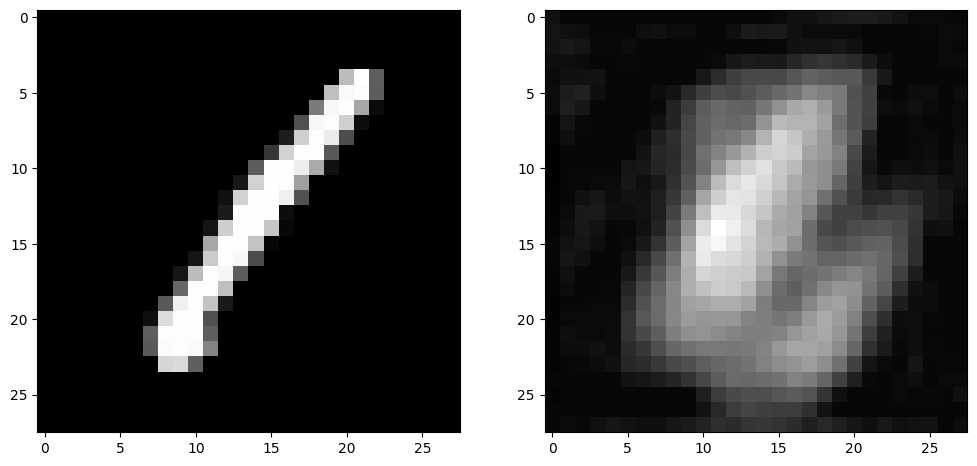

In [ ]:
n=1

fig = plt.figure(figsize=(12, 6))
fig.add_subplot(1, 2, 1)
plt.imshow(y[n], cmap='gray')
plt.show

fig.add_subplot(1, 2, 2)
plt.imshow(pred[n], cmap='gray')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

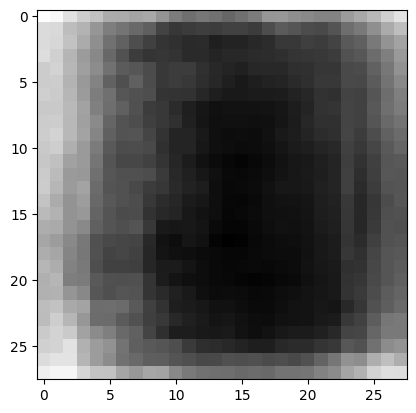

In [ ]:
plt.imshow(pred[7], cmap='gray')
plt.show

In [ ]:
def check(val):
    for i in range(28):
        for j in range(28):
            if val[i,j]<= 0:
                val[i,j] = 0
    return val

In [ ]:
val=tf.zeros([28,28])
val=pred[0]
check(val)
plt.imshow(pred[1], cmap='gray')
plt.show

Fast Access

In [ ]:
y_train_path='/datasets/image_1'
x_train_path='/datasets/image_conv_1'
y_test_path='/datasets/image_2'
x_test_path='/datasets/image_conv_2'

In [ ]:
filenames_train=os.listdir(y_train_path)
filenames_test=os.listdir(y_test_path)

In [ ]:
def load_image(img_path, img_conv_path):
    img, img_conv=tf.io.read_file(img_path), tf.io.read_file(img_conv_path)
    img, img_conv=tf.image.decode_png(img), tf.image.decode_png(img_conv)
    img, img_conv=tf.cast(img, tf.float32), tf.cast(img_conv, tf.float32)
    #img, img_conv=tf.reshape(img,[28,28,4]), tf.reshape(img_conv,[28,28,4])
    img, img_conv=tf.expand_dims(img[:,:,0], axis=-1), tf.expand_dims(img_conv[:,:,0], axis=-1)
    img, img_conv=img/255.0, img_conv/255.0
    return img, img_conv

In [ ]:
y_train, x_train=load_image(os.path.join(y_train_path, filenames_train[0]), os.path.join(x_train_path, filenames_train[0]))
y_test, x_test=load_image(os.path.join(y_test_path, filenames_test[0]), os.path.join(x_test_path, filenames_test[0]))
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

In [ ]:
x_train=[os.path.join(x_train_path,i) for i in filenames_train]
y_train=[os.path.join(y_train_path,i) for i in filenames_train]
x_test=[os.path.join(x_test_path,i) for i in filenames_test]
y_test=[os.path.join(y_test_path,i) for i in filenames_test]

In [ ]:
training_dataset=tf.data.Dataset.from_tensor_slices((x_train, y_train))
training_dataset=training_dataset.map(load_image).batch(25)

In [ ]:
test_dataset=tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset=test_dataset.map(load_image).batch(25)

In [ ]:
import keras
unet_model = keras.models.load_model("tanh.h5")

In [ ]:
@tf.function
def train_step(x,y):
    with tf.GradientTape(persistent=True) as tape:
        pred=unet_model(x, training=True)
        loss_=loss(pred,y)
    gradients=tape.gradient(loss_, unet_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, unet_model.trainable_variables))
    return loss_

In [ ]:
epochs=30
losses=[]
for epoch in range(1, epochs+1):
    batch_loss=[]
    for train_x, train_y in training_dataset:
        loss_=train_step(train_x, train_y)
        batch_loss.append(loss_)
    val_losses=[]
    for test_x, test_y in test_dataset:
        val_losses.append(loss(unet_model(test_x, training=False), test_y))
    losses.append(np.mean(batch_loss))
    print(f"Completed Epoch:{epoch} Training Loss: {np.mean(batch_loss)} Validation loss: {np.mean(val_losses)}")

In [ ]:
unet_model.save("tanh.h5")

In [ ]:
x,y=next(iter(test_dataset))
x.shape, y.shape
print(y[0])

In [ ]:
pred=unet_model(x)
pred.shape

In [ ]:
plt.imshow(y[1], cmap='gray')
plt.show

In [ ]:
print(y[16])

In [ ]:
plt.imshow(pred[1], cmap='gray')
plt.show